In [2]:
import numpy as np
import pandas as pd
import datetime
from datetime import date
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('/Users/hwiyoonkim/Desktop/STAT650 Project2/marketing_campaign.csv', sep="\t")


In [3]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# 3. Data Pre-Processing 
## 3.1 Handling Missing Values

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Marital_Status
data['Marital_Status_Encoded'] = le.fit_transform(data['Marital_Status'])

selected_numerical_cols = [
    'Income', 'Recency', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'NumStorePurchases'
]

reduced_data = data[['ID', 'Year_Birth', 'Education', 'Marital_Status_Encoded'] + selected_numerical_cols]

reduced_data_info = reduced_data.info()
reduced_data_head = reduced_data.head()

reduced_data_info, reduced_data_head

reduced_missing = reduced_data.isnull().sum()

if reduced_data['Income'].isnull().any():
    reduced_data['Income'].fillna(reduced_data['Income'].median(), inplace=True)

reduced_missing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      2240 non-null   int64  
 1   Year_Birth              2240 non-null   int64  
 2   Education               2240 non-null   object 
 3   Marital_Status_Encoded  2240 non-null   int64  
 4   Income                  2216 non-null   float64
 5   Recency                 2240 non-null   int64  
 6   MntWines                2240 non-null   int64  
 7   MntMeatProducts         2240 non-null   int64  
 8   NumWebPurchases         2240 non-null   int64  
 9   NumStorePurchases       2240 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 175.1+ KB


ID                         0
Year_Birth                 0
Education                  0
Marital_Status_Encoded     0
Income                    24
Recency                    0
MntWines                   0
MntMeatProducts            0
NumWebPurchases            0
NumStorePurchases          0
dtype: int64

## 3.2 Encoding Categorical Variables

In [7]:
# One-hot encoding to 'Education'
reduced_data_encoded = pd.get_dummies(reduced_data, columns=['Education'])

reduced_data_encoded.head()

,ID,Year_Birth,Marital_Status_Encoded,Income,Recency,MntWines,MntMeatProducts,NumWebPurchases,NumStorePurchases,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD
0,5524,1957,4,58138.0,58,635,546,8,4,False,False,True,False,False
1,2174,1954,4,46344.0,38,11,6,1,2,False,False,True,False,False
2,4141,1965,5,71613.0,26,426,127,8,10,False,False,True,False,False
3,6182,1984,5,26646.0,26,11,20,2,4,False,False,True,False,False
4,5324,1981,3,58293.0,94,173,118,5,6,False,False,False,False,True


## 3.3 Scaling and Normalization

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_cols_to_scale = ['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntMeatProducts', 
                           'NumWebPurchases', 'NumStorePurchases']

reduced_data_encoded[numerical_cols_to_scale] = scaler.fit_transform(reduced_data_encoded[numerical_cols_to_scale])
reduced_data_encoded.head()


,ID,Year_Birth,Marital_Status_Encoded,Income,Recency,MntWines,MntMeatProducts,NumWebPurchases,NumStorePurchases,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD
0,5524,-0.985345,4,0.235696,0.307039,0.983781,1.679702,1.409304,-0.550785,False,False,True,False,False
1,2174,-1.235733,4,-0.235454,-0.383664,-0.870479,-0.713225,-1.110409,-1.166125,False,False,True,False,False
2,4141,-0.317643,5,0.773999,-0.798086,0.362723,-0.177032,1.409304,1.295237,False,False,True,False,False
3,6182,1.268149,5,-1.022355,-0.798086,-0.870479,-0.651187,-0.750450,-0.550785,False,False,True,False,False
4,5324,1.017761,3,0.241888,1.550305,-0.389085,-0.216914,0.329427,0.064556,False,False,False,False,True


# 4. Exploratory Data Analysis (EDA) 
## 4.1 Descriptive Statistics

### Univariate Analysis

In [16]:
import pandas as pd
descriptive_stats = data.describe()

print("Descriptive Statistics:\n", descriptive_stats)

Descriptive Statistics:
                  ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000   

### Histograms:

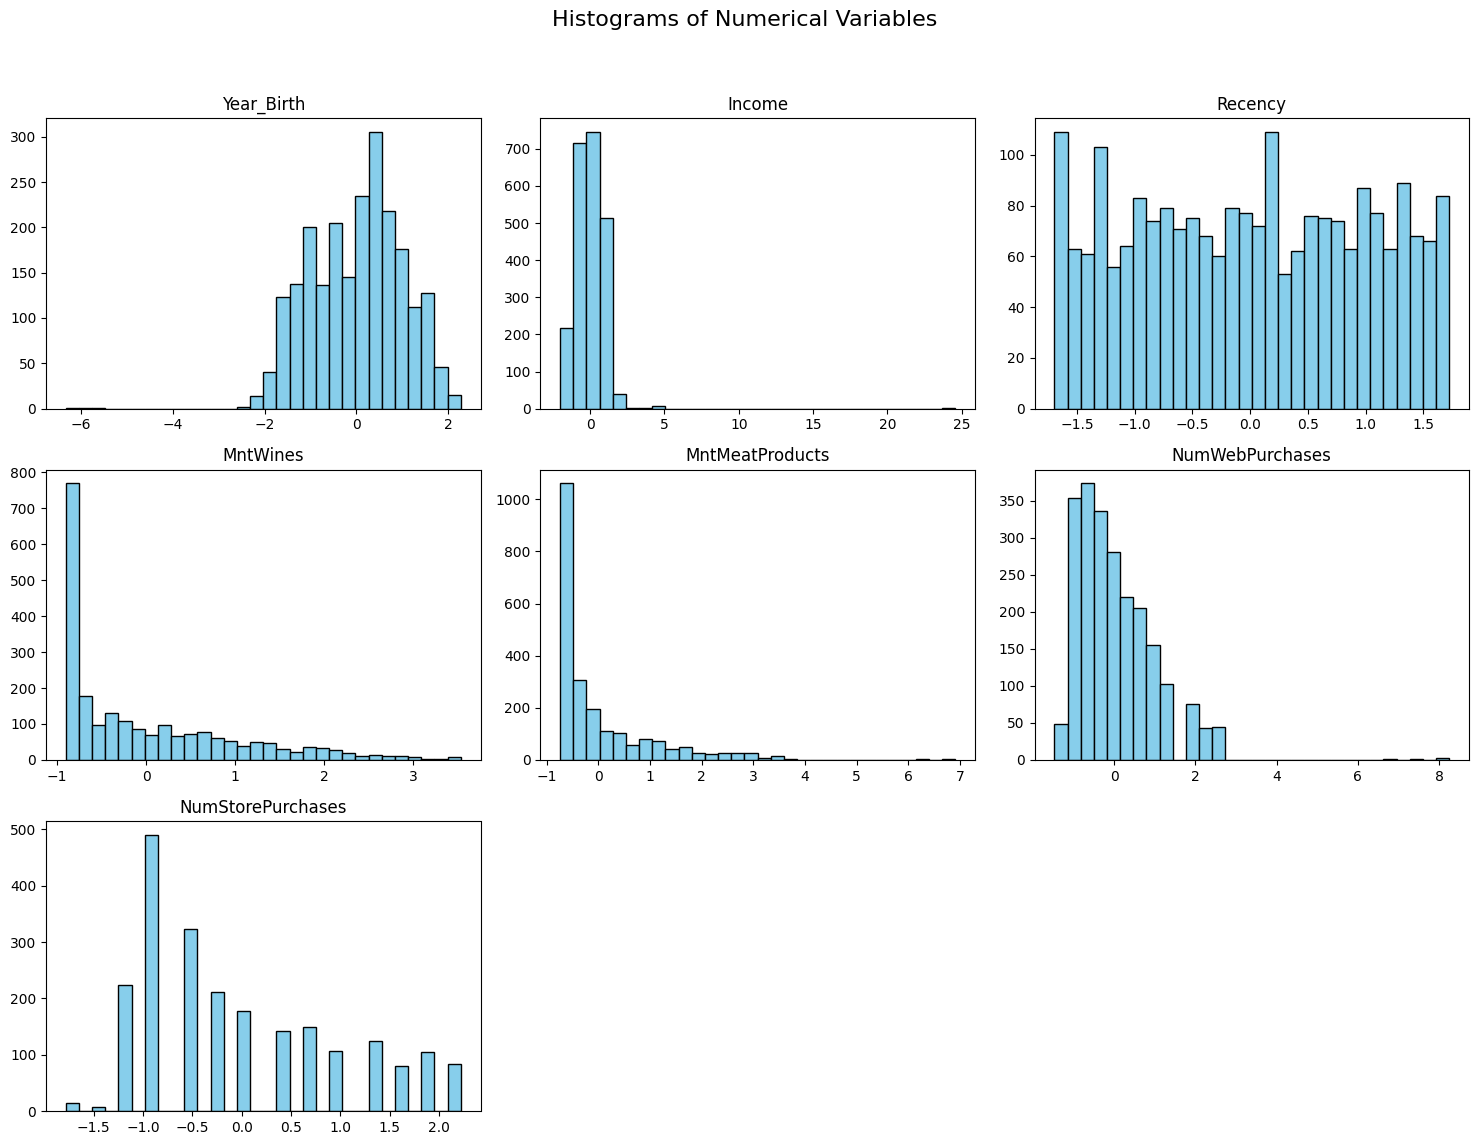

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle('Histograms of Numerical Variables', fontsize=16)

axes = axes.flatten()
for i, col in enumerate(numerical_cols_to_scale):
    axes[i].hist(reduced_data_encoded[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for ax in axes[len(numerical_cols_to_scale):]:
    fig.delaxes(ax)

plt.show()


### Box Plots:

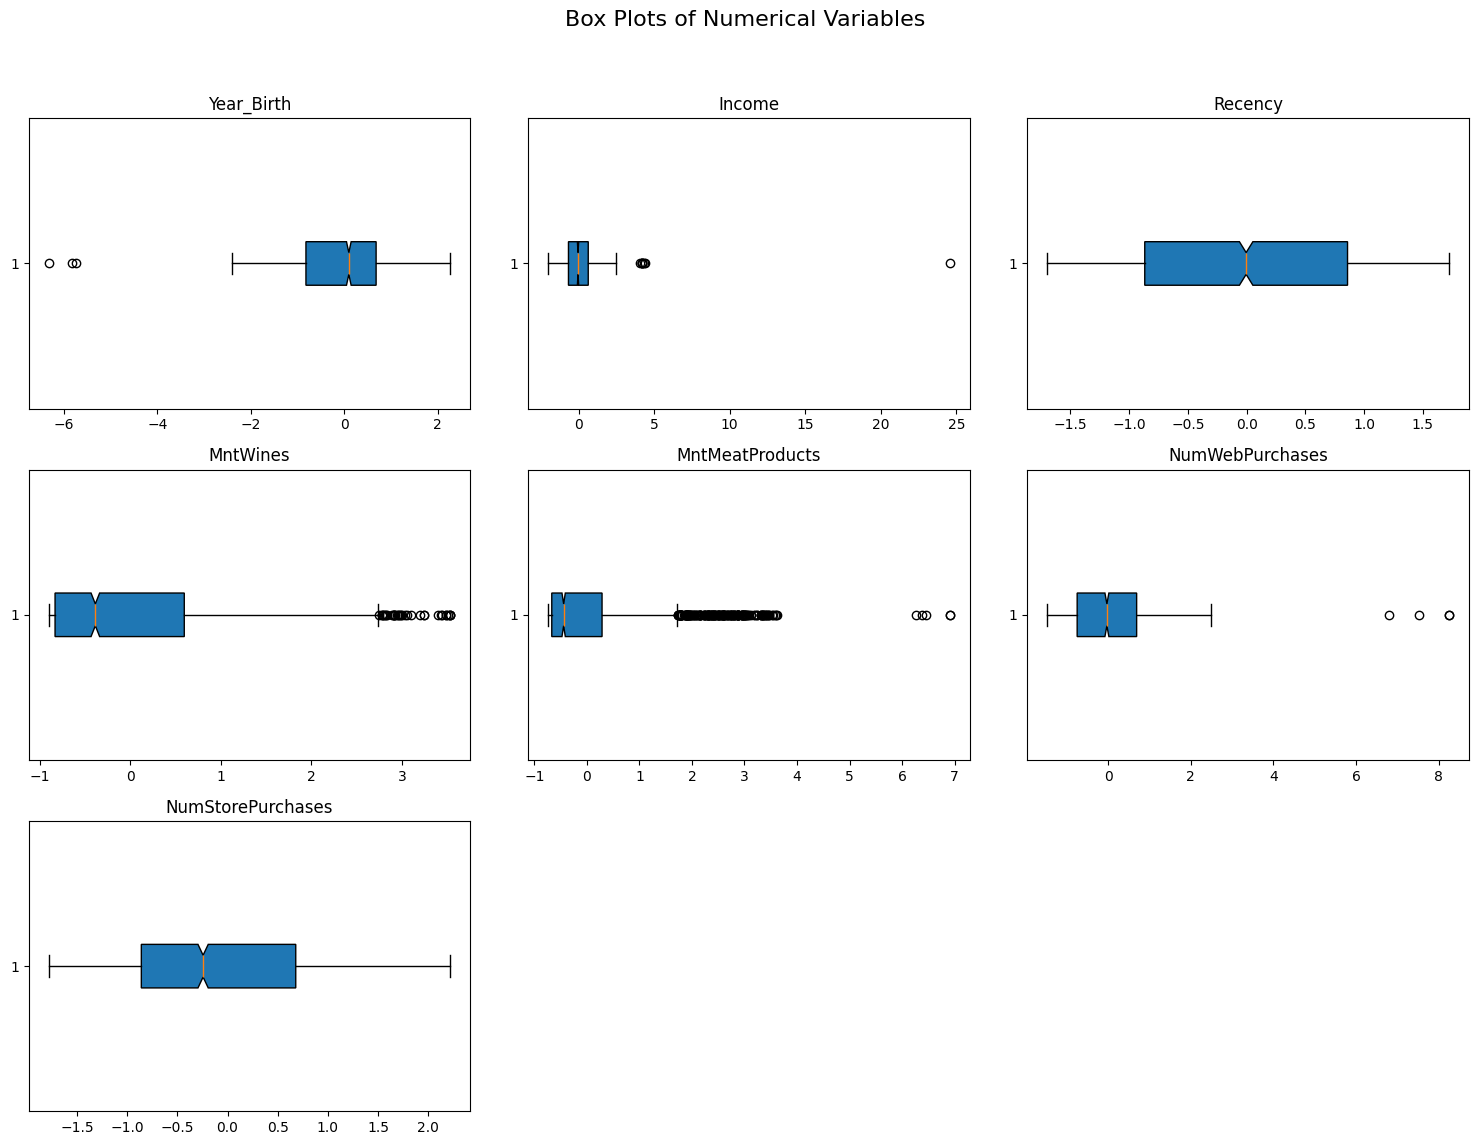

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle('Box Plots of Numerical Variables', fontsize=16)

axes = axes.flatten()

for i, col in enumerate(numerical_cols_to_scale):
    axes[i].boxplot(reduced_data_encoded[col], patch_artist=True, notch=True, vert=False)
    axes[i].set_title(col)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for ax in axes[len(numerical_cols_to_scale):]:
    fig.delaxes(ax)

plt.show()


### Scattor Plots: 

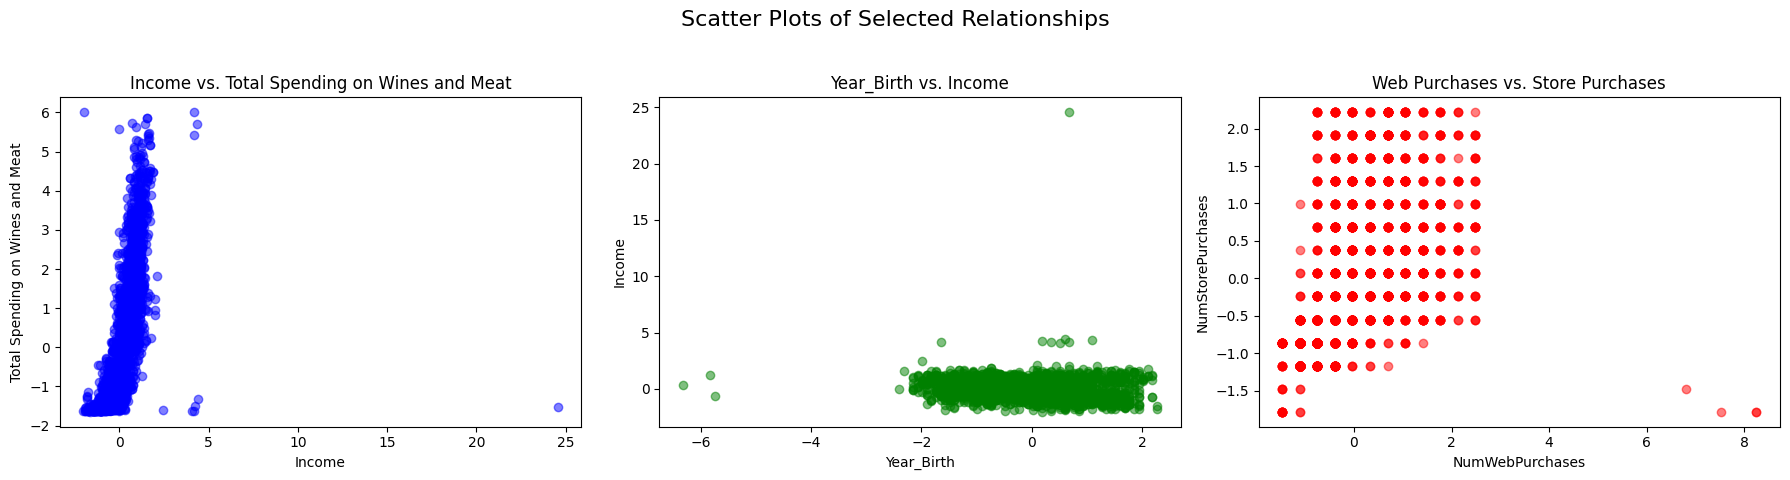

In [23]:
# Plotting scatter plots for selected relationships
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.suptitle('Scatter Plots of Selected Relationships', fontsize=16)

# Income vs. Total Spending (combining wine and meat products)
total_spending = reduced_data_encoded['MntWines'] + reduced_data_encoded['MntMeatProducts']
axes[0].scatter(reduced_data_encoded['Income'], total_spending, alpha=0.5, color='blue')
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Total Spending on Wines and Meat')
axes[0].set_title('Income vs. Total Spending on Wines and Meat')

# Year_Birth vs. Income
axes[1].scatter(reduced_data_encoded['Year_Birth'], reduced_data_encoded['Income'], alpha=0.5, color='green')
axes[1].set_xlabel('Year_Birth')
axes[1].set_ylabel('Income')
axes[1].set_title('Year_Birth vs. Income')

# NumWebPurchases vs. NumStorePurchases
axes[2].scatter(reduced_data_encoded['NumWebPurchases'], reduced_data_encoded['NumStorePurchases'], alpha=0.5, color='red')
axes[2].set_xlabel('NumWebPurchases')
axes[2].set_ylabel('NumStorePurchases')
axes[2].set_title('Web Purchases vs. Store Purchases')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Bivariate Analysis

Correlation Matrix:
                   Year_Birth    Income   Recency  MntWines  MntMeatProducts  \
Year_Birth           1.000000 -0.161791 -0.019871 -0.157773        -0.030872   
Income              -0.161791  1.000000 -0.003970  0.578650         0.584633   
Recency             -0.019871 -0.003970  1.000000  0.016064         0.023056   
MntWines            -0.157773  0.578650  0.016064  1.000000         0.562667   
MntMeatProducts     -0.030872  0.584633  0.023056  0.562667         1.000000   
NumWebPurchases     -0.145040  0.387878 -0.010726  0.542265         0.293761   
NumStorePurchases   -0.128272  0.529362  0.000799  0.642100         0.479659   

                   NumWebPurchases  NumStorePurchases  
Year_Birth               -0.145040          -0.128272  
Income                    0.387878           0.529362  
Recency                  -0.010726           0.000799  
MntWines                  0.542265           0.642100  
MntMeatProducts           0.293761           0.479659  
Num

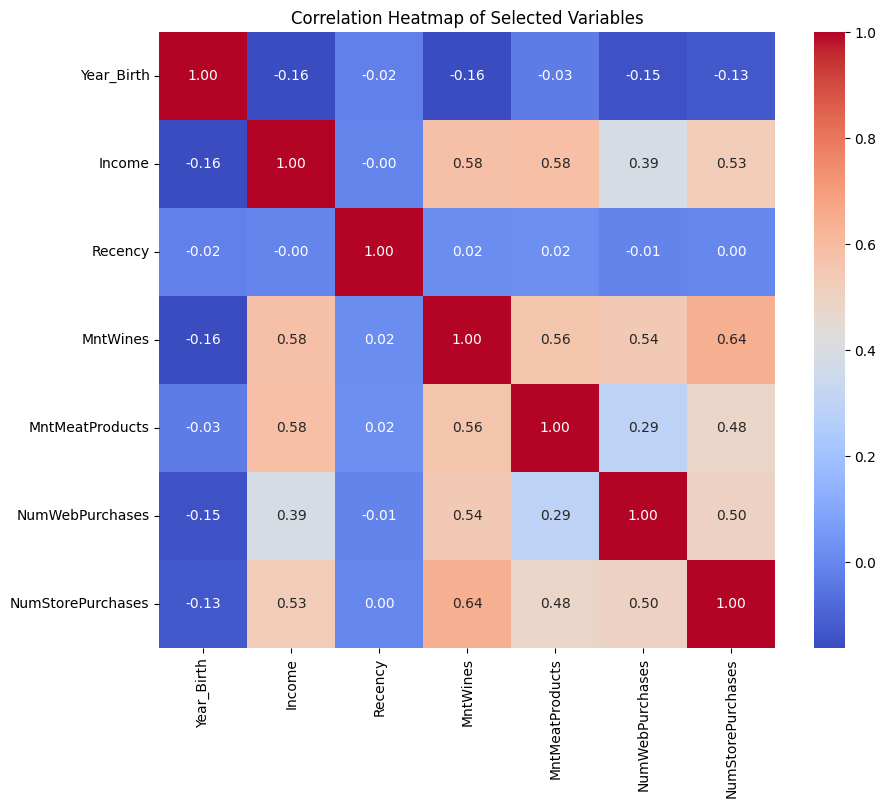

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
selected_columns = data[['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'NumStorePurchases']]

correlation_matrix = selected_columns.corr()
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Selected Variables')
plt.show()

### Multivariate Analysis

Recency Quartile Distribution:
Recency_Quartiles
Q1    567
Q3    567
Q2    555
Q4    551
Name: count, dtype: int64

Mean Wine Spending and Income by Recency Quartile:
                     MntWines        Income
Recency_Quartiles                          
Q1                 290.656085  52976.740214
Q2                 298.299099  51359.818512
Q3                 333.299824  52952.950178
Q4                 293.061706  51660.190388


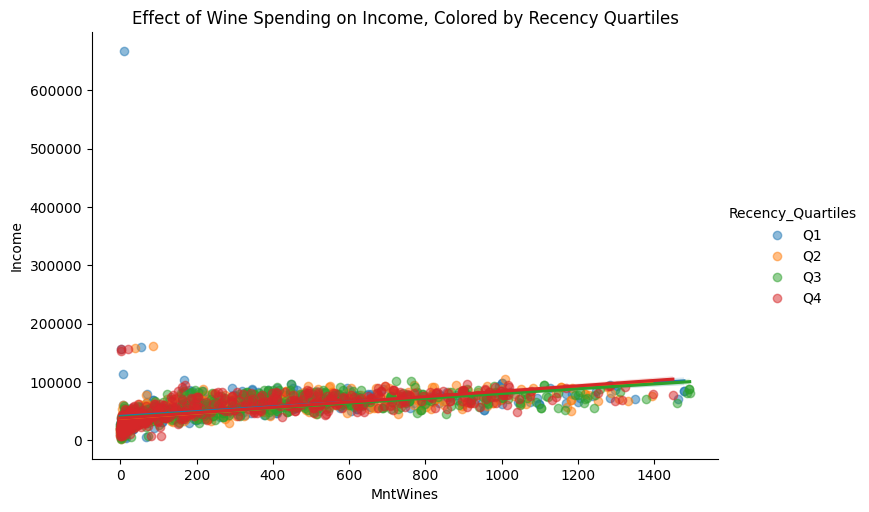

In [129]:
print("Recency Quartile Distribution:")
print(data['Recency_Quartiles'].value_counts())


quartile_means = data.groupby('Recency_Quartiles')[['MntWines', 'Income']].mean()
print("\nMean Wine Spending and Income by Recency Quartile:")
print(quartile_means)

data['Recency_Quartiles'] = pd.qcut(data['Recency'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
sns.lmplot(x='MntWines', y='Income', hue='Recency_Quartiles', data=data, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title('Effect of Wine Spending on Income, Colored by Recency Quartiles')
plt.show()

# 5. Regression Analysis

## 5.1 Simple Linear Regression

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Predictor and response
X = reduced_data[['Income']]  # Predictor
y = reduced_data['MntWines']  # Response

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and fit the linear regression model
simple_lr = LinearRegression()
simple_lr.fit(X_train, y_train)

# Display coefficients
print(f"Intercept: {simple_lr.intercept_}")
print(f"Coefficient of Income: {simple_lr.coef_[0]}")



Intercept: -60.79299040025177
Coefficient of Income: 0.006906419273283958


In [91]:
# Prediction and Evaluation
y_pred = simple_lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 62351.62338067439
R^2 Score: 0.41970649027931073


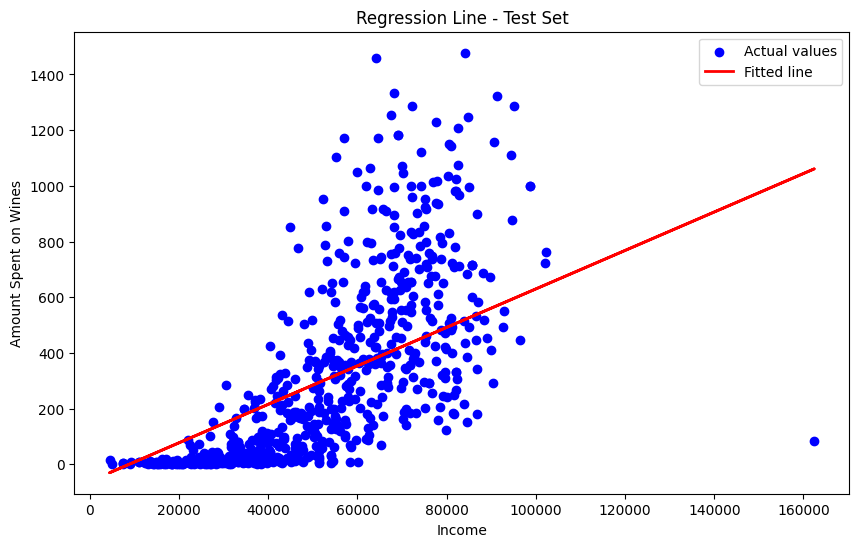

In [93]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual values')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Fitted line')
plt.title('Regression Line - Test Set')
plt.xlabel('Income')
plt.ylabel('Amount Spent on Wines')
plt.legend()
plt.show()

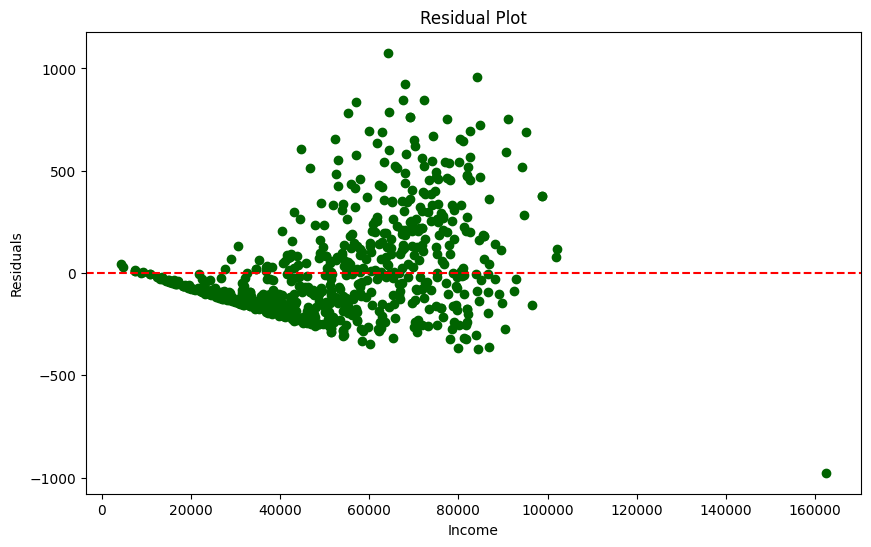

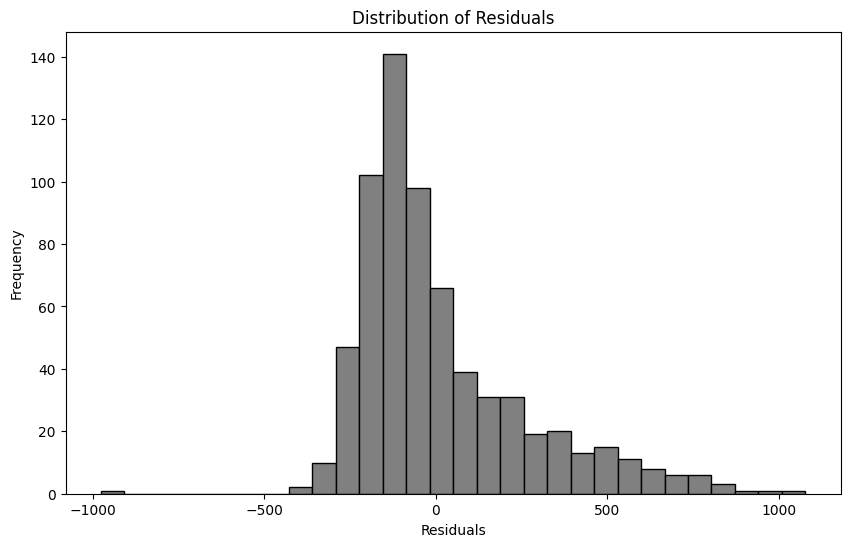

In [95]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(X_test, residuals, color='darkgreen')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Income')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='grey', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


## 5.2 Multiple Linear Regression

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = reduced_data[['Income', 'Recency', 'NumWebPurchases', 'NumStorePurchases']]
y = reduced_data['MntWines']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [100]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


Mean Squared Error: 46693.882047834515
Root Mean Squared Error: 216.08767213294357
R-squared: 0.5654298119779171


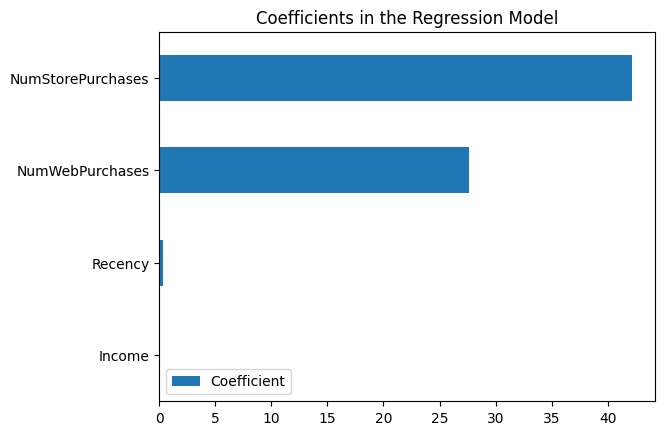

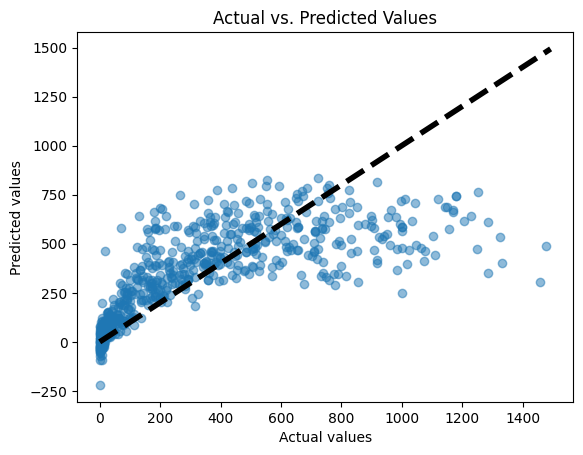

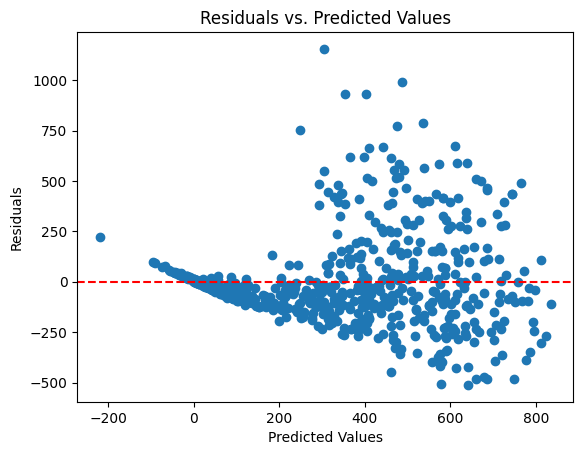

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Coefficients visualization
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients.plot(kind='barh')
plt.title('Coefficients in the Regression Model')
plt.show()

# Predictions vs Actual values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

## 5.3 Polynomial Regression

In [105]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)  # Using a quadratic model
X_poly = poly.fit_transform(X_train[['Income']])

poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)

X_test_poly = poly.transform(X_test[['Income']])
y_pred_poly = poly_model.predict(X_test_poly)

print(f"Intercept: {poly_model.intercept_}")
print(f"Coefficients: {poly_model.coef_}")


Intercept: -311.06864436157434
Coefficients: [ 0.00000000e+00  1.29690584e-02 -1.90226105e-08]


In [107]:
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Polynomial Regression MSE: {mse_poly}")
print(f"Polynomial Regression RMSE: {rmse_poly}")
print(f"Polynomial Regression R^2: {r2_poly}")


Polynomial Regression MSE: 54651.015230104305
Polynomial Regression RMSE: 233.77556593900977
Polynomial Regression R^2: 0.4913744387366574


## 5.4 Logistic Regression

In [110]:
from sklearn.linear_model import LogisticRegression

# Binary target variable
y_binary = (y_train > y_train.median()).astype(int)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_binary)

y_test_binary = (y_test > y_train.median()).astype(int)
y_pred_log = log_reg.predict(X_test)

print(f"Intercept: {log_reg.intercept_}")
print(f"Coefficients: {log_reg.coef_}")

Intercept: [-7.96688127]
Coefficients: [[ 3.49626386e-05 -1.88844804e-03  2.42479540e-01  1.05150655e+00]]


In [112]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test_binary, y_pred_log)
report = classification_report(y_test_binary, y_pred_log)

print(f"Logistic Regression Accuracy: {accuracy}")
print(report)


Logistic Regression Accuracy: 0.9077380952380952
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       297
           1       0.91      0.92      0.92       375

    accuracy                           0.91       672
   macro avg       0.91      0.91      0.91       672
weighted avg       0.91      0.91      0.91       672



## 5.5 Regularization Techniques

In [115]:
from sklearn.linear_model import Lasso, Ridge

# LASSO Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Ridge Regression
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("LASSO Coefficients:", lasso.coef_)
print("Ridge Coefficients:", ridge.coef_)


LASSO Coefficients: [3.32824015e-03 3.55900552e-01 2.75808732e+01 4.21195765e+01]
Ridge Coefficients: [3.32734146e-03 3.56051378e-01 2.75921532e+01 4.21273423e+01]


In [117]:
# LASSO
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"LASSO MSE: {mse_lasso}, R^2: {r2_lasso}")
print(f"Ridge MSE: {mse_ridge}, R^2: {r2_ridge}")


LASSO MSE: 46692.85802174924, R^2: 0.5654393423743823
Ridge MSE: 46693.84007568954, R^2: 0.5654302026038863


In [119]:
from sklearn.linear_model import ElasticNet

# Elastic Net Regression
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
y_pred_elastic = elastic_net.predict(X_test)

print("Elastic Net Coefficients:", elastic_net.coef_)

mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

print(f"Elastic Net MSE: {mse_elastic}, R^2: {r2_elastic}")


Elastic Net Coefficients: [3.34493787e-03 3.55585317e-01 2.74798343e+01 4.19052649e+01]
Elastic Net MSE: 46661.184479031115, R^2: 0.565734121407752


# Model Evaluation and Comparison

### Regression Models: Lower MSE and higher R^2 values indicate better performance.
### Classification Models: Higher accuracy and F1-scores indicate better predictive ability.

In [122]:
print(f"Polynomial Regression - MSE: {mse_poly}, R^2: {r2_poly}")
print(f"Logistic Regression - Accuracy: {accuracy}")
print(f"LASSO Regression - MSE: {mse_lasso}, R^2: {r2_lasso}")
print(f"Ridge Regression - MSE: {mse_ridge}, R^2: {r2_ridge}")
print(f"Elastic Net Regression - MSE: {mse_elastic}, R^2: {r2_elastic}")


Polynomial Regression - MSE: 54651.015230104305, R^2: 0.4913744387366574
Logistic Regression - Accuracy: 0.9077380952380952
LASSO Regression - MSE: 46692.85802174924, R^2: 0.5654393423743823
Ridge Regression - MSE: 46693.84007568954, R^2: 0.5654302026038863
Elastic Net Regression - MSE: 46661.184479031115, R^2: 0.565734121407752


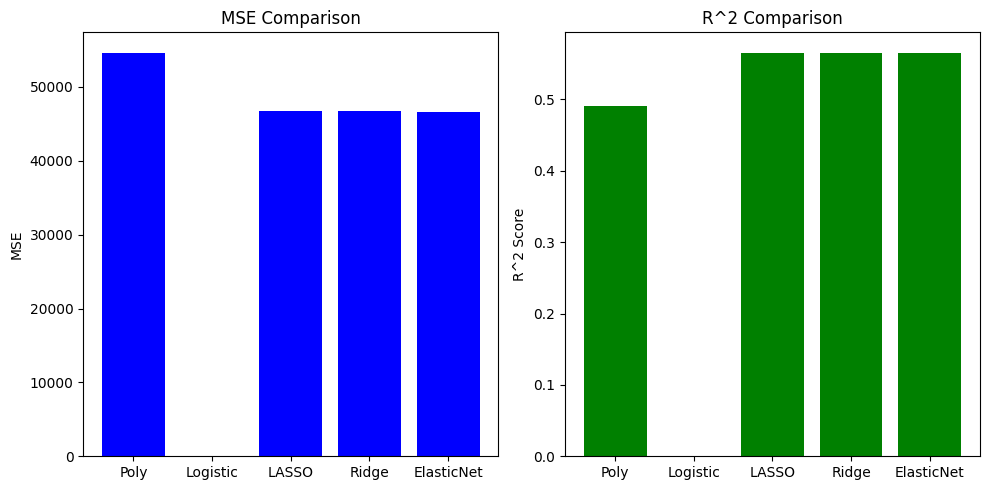

In [124]:
import matplotlib.pyplot as plt


models = ['Poly', 'Logistic', 'LASSO', 'Ridge', 'ElasticNet']
mse_values = [mse_poly, np.nan, mse_lasso, mse_ridge, mse_elastic]  # Logistic regression does not use MSE
r2_values = [r2_poly, np.nan, r2_lasso, r2_ridge, r2_elastic]  # Logistic regression does not use R^2

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mse_values, color='blue')
plt.title('MSE Comparison')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color='green')
plt.title('R^2 Comparison')
plt.ylabel('R^2 Score')

plt.tight_layout()
plt.show()
